#### TENTATIVE UTLISATION DU TMJA dans le score

Notebook amorcé par : Jesshuan

Deuxième test cette fois sur la région Bretagne

Objectifs :

- à partir des fichiers geopandas "dataset_communes", "dataset_charge_points" et "TMJA2018" précedemment récupérés et complétés par l'équipe, évaluer la faisabilité et la pertinence des ompositions de sous-scores décrit dans les "Pistes de scores" (https://www.notion.so/dataforgood/New-Pistes-pour-le-score-1410a2aff0ee4b11b073b1850c87a95e) pour les sous-scores 1 et 2, qui font intervenir le TJMA "touristique", à savoir le TJMA de chaque route amputée de sa composante "locale".

- dans tous les cas, en profiter pour manier les alogorithmes de calcul type "plus proche route d'une commune", qui sera de toutes façons très certainement utilisé

- factoriser le code depuis le premier test Bouches-du-Rhône, enlever la partie analyse technique...

Imports :

In [1]:
import geopandas as gpd
import geopy.distance
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import copy

In [2]:
# data_path = 'C:/Users/demo/Desktop/Lattitude/datas/'
data_path = 'datas'
os.makedirs(data_path, exist_ok=True)

In [40]:
# OPTIONNAL : Import et test avec TMJA 2019, qui est un fichier plus incomplet (et routes encore plus discontinues...) que 2018

'''# tmja = gpd.read_file('C:/Users/demo/Desktop/Lattitude/datas/tmja2018-shp/TMJA2018.shp')
file_name = 'TMJA2019'
ext = '.shp'
url = 'https://static.data.gouv.fr/resources/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/20211222-170254/tmja2019-shp.zip'
temp_path = 'temp_unzip'

try: 
    tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))
except:
    # From url
    zip_file = requests.get(url).content
    os.makedirs(temp_path, exist_ok=True)
    with zipfile.ZipFile(io.BytesIO(zip_file)) as archive:
        archive.extractall(temp_path)
    tmja = gpd.read_file(os.path.join(temp_path,file_name + ext))
    shutil.rmtree(temp_path)

    # From local file
    # tmja = gpd.read_file(os.path.join(data_path,file_name + ext))

    # avoiding multi dowloads for GES emmision lowering
    tmja.to_feather(os.path.join(data_path,file_name + '.feather'))'''

"# tmja = gpd.read_file('C:/Users/demo/Desktop/Lattitude/datas/tmja2018-shp/TMJA2018.shp')\nfile_name = 'TMJA2019'\next = '.shp'\nurl = 'https://static.data.gouv.fr/resources/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/20211222-170254/tmja2019-shp.zip'\ntemp_path = 'temp_unzip'\n\ntry: \n    tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))\nexcept:\n    # From url\n    zip_file = requests.get(url).content\n    os.makedirs(temp_path, exist_ok=True)\n    with zipfile.ZipFile(io.BytesIO(zip_file)) as archive:\n        archive.extractall(temp_path)\n    tmja = gpd.read_file(os.path.join(temp_path,file_name + ext))\n    shutil.rmtree(temp_path)\n\n    # From local file\n    # tmja = gpd.read_file(os.path.join(data_path,file_name + ext))\n\n    # avoiding multi dowloads for GES emmision lowering\n    tmja.to_feather(os.path.join(data_path,file_name + '.feather'))"

In [3]:
# Load the data for French garge points
file_name = 'dataset_charge_points.feather'

bornes = gpd.read_feather(os.path.join(data_path, file_name))

# Load the data for the communes
file_name = 'dataset_communes.feather'

datas = gpd.read_feather(os.path.join(data_path, file_name))

file_name = 'TMJA2018'

tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))

--------

Conversion dans le système ws84 (coordonnées GPS standard) :

In [4]:
tmja_wrs84 = tmja.to_crs(4326)

Zoom autour de la Bretagne :

In [24]:
to_keep = (tmja_wrs84['xD']>=800000) & (tmja_wrs84['xD']<=1600000) & (tmja_wrs84['yD']<=6600000) & (tmja_wrs84['yD']>=5500000)

tmja_wrs84_bre = tmja_wrs84.loc[to_keep,:]

<Axes: >

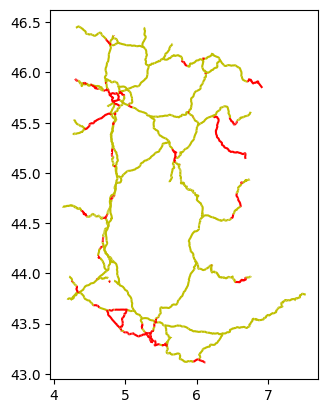

In [25]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84_bre.loc[tmja_wrs84_bre['tmja']>0,:].plot(ax=ax, color='y')
tmja_wrs84_bre.loc[tmja_wrs84_bre['tmja']==0,:].plot(ax=ax, color='r')

Piste : Extrapolation du traffic possible par déduction via les plus proches voisines non nulles (de manière itérative)

La fonction ci-dessous extrapole le tmja des routes aux tmja nuls, grâce aux routes strictement adjacentes (point de départ = point d'arrivée de la route adjacente, point d'arrivée = point de départ de la route adjacente, point de départ = point de départ...) Une moyenne est faite parmi toutes les routes trouvées adjacentes (moyenne des routes à gauche et à droite, ou une seule route dans le cas d'une impasse, etc...)
Le processus est réitéré n fois (n défini à 30 ici), pour permettre le plus de complétion possibles (progression de proche en proche, dans le cas où plusieurs routes avec un tmja nulle se succède)


In [26]:
def split_and_fill_Local_null_values_by_key(df, column_key, missing_value=0,nb_rep=10, buffer_size=0.01):

    geometry_conservation = df.geometry

    df_clean = copy.copy(df)

    try:
        df_clean.reset_index(names="road_index", inplace=True)
    except Exception as e:
        print(e)
        pass

    df_buf = df_clean.buffer(buffer_size)

    df_clean.geometry = df_buf

    total_values = 0

    for k in range(nb_rep):

        new_column = []
        values = 0

        column_list = df_clean[column_key].to_list()
        index_list = df_clean['road_index'].to_list()

        df_join_road = df_clean.sjoin(df_clean, how='inner')
        df_join_road_clean = df_join_road.loc[df_join_road['road_index_left']!=df_join_road['road_index_right'],:]
        dict_new = df_join_road_clean[['road_index_left',f'{column_key}_right']].groupby('road_index_left').mean().to_dict()[f'{column_key}_right']

        for i, index in enumerate(index_list):
            old_tmja = column_list[i]
            if old_tmja == missing_value or str(old_tmja)==missing_value:
                try:
                    new_column.append(dict_new[index])
                    values+=1
                except:
                    new_column.append(old_tmja)
            else:
                new_column.append(old_tmja)
        
        df_clean[column_key] = new_column
    
        total_values += values

        print(f'... {k+1} rounds done. {values} are been modified... Total values modified : {total_values}')
    
    df_clean.geometry = geometry_conservation

    return df_clean

In [27]:
tmja_wrs84_clean = split_and_fill_Local_null_values_by_key(tmja_wrs84, column_key='tmja', nb_rep=15)

/tmp/ipykernel_52500/3422367474.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_buf = df_clean.buffer(buffer_size)


... 1 rounds done. 1543 are been modified... Total values modified : 1543
... 2 rounds done. 571 are been modified... Total values modified : 2114
... 3 rounds done. 312 are been modified... Total values modified : 2426
... 4 rounds done. 172 are been modified... Total values modified : 2598
... 5 rounds done. 87 are been modified... Total values modified : 2685
... 6 rounds done. 49 are been modified... Total values modified : 2734
... 7 rounds done. 29 are been modified... Total values modified : 2763
... 8 rounds done. 19 are been modified... Total values modified : 2782
... 9 rounds done. 17 are been modified... Total values modified : 2799
... 10 rounds done. 12 are been modified... Total values modified : 2811
... 11 rounds done. 7 are been modified... Total values modified : 2818
... 12 rounds done. 3 are been modified... Total values modified : 2821
... 13 rounds done. 1 are been modified... Total values modified : 2822
... 14 rounds done. 0 are been modified... Total values mo

Résultats de la complétion (sur la zone Bretagne) :

In [28]:
to_keep = (tmja_wrs84['xD']>=800000) & (tmja_wrs84['xD']<=1600000) & (tmja_wrs84['yD']<=6600000) & (tmja_wrs84['yD']>=5500000)

tmja_wrs84_bre = tmja_wrs84_clean.loc[to_keep,:]

<Axes: >

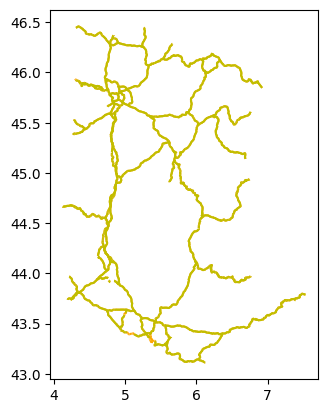

In [30]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84_bre.loc[tmja_wrs84_bre['tmja']>0,:].plot(ax=ax, color='orange')
tmja_wrs84_bre.loc[tmja_wrs84_bre['tmja']>1000,:].plot(ax=ax, color='y')
#tmja_wrs84_dep13_clean.loc[tmja_wrs84_dep13_clean['tmja']==0,:].plot(ax=ax, color='r')

-----

On récupère aussi les centres de routes :

In [31]:
tmja_wrs84_clean['Road_center'] = tmja_wrs84_clean.to_crs('+proj=cea').geometry.centroid.to_crs(tmja_wrs84.crs)

---------

Données des communes :

Les lignes des données de communes sont redondantes, car les données d'enregistrement des véhicules sont trimestriels. On récupère donc ici seulement les données les plus actuelles :

In [32]:
communes_fin_2022 = datas.loc[datas['date_arrete']=='2022-12-31']

On ne va garder que les communes en métropole :

In [33]:
extra_metropole = [code_insee for code_insee in communes_fin_2022['insee'].to_list() if code_insee[0:2]=='2A' or code_insee[0:2]=='2B' or code_insee[0:2]=='97' or code_insee[0:2]=='98']

In [34]:
communes_metropole = communes_fin_2022.loc[~communes_fin_2022['insee'].isin(extra_metropole),:]

On ajoute une colonne au dataframe pour accéder directement au centre de la commune :

In [35]:
communes_metropole['coords_centre'] = communes_metropole.to_crs('+proj=cea').geometry.centroid.to_crs(communes_metropole.crs)

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


-----------

TENTATIVE DE DISSOCIATION DU TMJA EN TJMA GLOBAL ET TJMA TOURSTIQUE :

Test effectué sur le département des Bouches-du-Rhône, pour réduire le (long !) temps de calcul...

In [36]:
dep_bre = [code_insee for code_insee in communes_metropole['insee'].to_list() if code_insee[0:2] in ['04', '05', '06', '13', '83', '84']]

In [37]:
len(dep_bre)

946

In [38]:
communes_bre = communes_metropole.loc[communes_metropole['insee'].isin(dep_bre),:]

In [39]:
communes_bre.head()

,insee,nom,wikipedia,surf_ha,geometry,PMUN,PCAP,PTOT,nb_vp,libepci,libgeo,nb_vp_rechargeables_gaz,date_arrete,epci,nb_vp_rechargeables_el,dep,dep_name,region_name,coords_centre
260,05139,Le Dévoluy,fr:Dévoluy (commune),18752.0,"POLYGON ((5.79038 44.65376, 5.79044 44.65395, ...",966.0,27.0,993.0,1170.0,CC Buëch-Dévoluy,DÉVOLUY,0.0,2022-12-31,200067445,11.0,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur,POINT (5.89103 44.68466)
466,05077,Molines-en-Queyras,fr:Molines-en-Queyras,5392.0,"POLYGON ((6.80025 44.71754, 6.80386 44.71814, ...",300.0,5.0,305.0,371.0,CC du Guillestrois et du Queyras,MOLINES-EN-QUEYRAS,0.0,2022-12-31,200067452,2.0,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur,POINT (6.89327 44.71665)
790,05107,Puy-Saint-André,fr:Puy-Saint-André,1530.0,"POLYGON ((6.51872 44.89477, 6.51917 44.89542, ...",462.0,25.0,487.0,591.0,CC du Briançonnais,PUY-SAINT-ANDRÉ,0.0,2022-12-31,240500439,5.0,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur,POINT (6.56660 44.89131)
829,05093,Névache,fr:Névache,19182.0,"POLYGON ((6.47896 45.09299, 6.47897 45.09308, ...",356.0,11.0,367.0,423.0,CC du Briançonnais,NÉVACHE,1.0,2022-12-31,240500439,2.0,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur,POINT (6.59883 45.04407)
830,05063,La Grave,fr:La Grave,12418.0,"POLYGON ((6.20079 45.02147, 6.20081 45.02218, ...",482.0,10.0,492.0,570.0,CC du Briançonnais,LA GRAVE,0.0,2022-12-31,240500439,5.0,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur,POINT (6.28356 45.05999)


Définition du périmètre de sélection initial (pour limiter les calculs) : un cercle de grand rayon (70 km à vol d'oiseau) en s'assurant que toute commune possède bien au moins une route dans ce rayon, dans la France entière.
Pour chaque commune, on va d'abord dresser la liste de toutes les routes éligibles (selon distance à vol d'oiseau) dans ce rayon, avant de passer à un calcul plus précis...

In [40]:
DIST_VOL_OISEAU = 70000 # meters

In [41]:
nearlier_road = []
nearlier_road_dist = []
multiline_road = []
problematic_road = []

for k, coord_center in enumerate(communes_bre['coords_centre'].geometry): # pour chaque commune (centre de commune)

    list_index_nearly = []
    list_coord_nearly = []
    list_dist = []


    # ETAPE 1 - SELECTION "À LA LOUCHE" DES ROUTES DANS LE BON RAYON LARGE

    for i, road_center in enumerate(tmja_wrs84_clean['Road_center'].geometry): # pour chaque route du fichier

        dist_oiseau = geopy.distance.geodesic(coord_center.coords, road_center.coords).meters #
        if dist_oiseau<=DIST_VOL_OISEAU: # on ne garde la route que si elle est incluse dans le périmètre défini
            list_index_nearly.append(i)
            try:
                # Ajout de toutes les coordonnées de tous les points de la route dans la liste :
                list_coord_nearly.append([tupple_coord for tupple_coord in tmja_wrs84.geometry.to_list()[i].coords])
            except:
                try:
                    # En cas de MultiStrings (routes discontinues)...
                    # À défaut, ajout de toutes les coordonnées de tous les points de la route dans la liste, en cassant différemment le format :
                    list_coord_nearly.append([tupple for linestring in tmja_wrs84.geometry[i].geoms for tupple in linestring.coords])
                    multiline_road.append(tmja_wrs84_clean.iloc[i, 1])
                except:
                    # En cas de nouveau problème...
                    # On enregistre seulement le centre de la route... (dommage)
                    # On enregistre l'index de la route problématique
                    list_coord_nearly.append([road_center.coords])
                    problematic_road.append(tmja_wrs84_clean.iloc[i, 1])

    
    # ETAPE 2 - CALCUL DE DISTANCE À CHAQUE POINT ROUTE

    # ICI, REMPLACER PAR CALCUL API DE DISTANCE TEMPORELLE ROUTIERE :
    # BOUCLE AVEC REQUETES À L'API POUR EVALUATION DU TEMPS ROUTIER DU POINT COMMUNE/CENTRE-VILLAGE
    # À CHAQUE POINT DE ROUTE DE LA LISTE
    #for coord_road in list_coord_nearly:
        # ...
        # best_dist =
        # best_index = 

    # SOLUTION DE REMPLACEMENT (VOL D'OISEAU) :

    dist_minimal = DIST_VOL_OISEAU # défnition de la distance par défaut minimale

    for i, road_list_points in enumerate(list_coord_nearly):

        min_for_this_road = min([geopy.distance.geodesic(coord_center.coords, tupple).meters for tupple in road_list_points])

        if min_for_this_road < dist_minimal:
            dist_minimal = min_for_this_road

            best_road = list_index_nearly[i]


    # ETAPE 3 - ENREGISTREMENT DE LA ROUTE LA PLUS PROCHE + DISTANCE À CETTE ROUTE

    nearlier_road_dist.append(dist_minimal)

    nearlier_road.append(best_road)

    if k%10==0:
        print(f'{k} communes completed...')

#communes_metropole['nearlier_road'] = nearlier_road
#communes_metropole['nearlier_road_dist']=  nearlier_road_dist

communes_bre['nearlier_road'] = nearlier_road
communes_bre['nearlier_road_dist']=  nearlier_road_dist

0 communes completed...
10 communes completed...
20 communes completed...
30 communes completed...
40 communes completed...
50 communes completed...
60 communes completed...
70 communes completed...
80 communes completed...
90 communes completed...
100 communes completed...
110 communes completed...
120 communes completed...
130 communes completed...
140 communes completed...
150 communes completed...
160 communes completed...
170 communes completed...
180 communes completed...
190 communes completed...
200 communes completed...
210 communes completed...
220 communes completed...
230 communes completed...
240 communes completed...
250 communes completed...
260 communes completed...
270 communes completed...
280 communes completed...
290 communes completed...
300 communes completed...
310 communes completed...
320 communes completed...
330 communes completed...
340 communes completed...
350 communes completed...
360 communes completed...
370 communes completed...
380 communes completed.

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Sauvegarde du fichier :

In [42]:
file_name = 'communes_with_nearlier_road_paca_test.feather'

communes_bre.to_feather(os.path.join(data_path, file_name))

Import du fichier :

In [21]:
file_name = 'communes_with_nearlier_road_bretagne_test.feather'

communes_bre = gpd.read_feather(os.path.join(data_path, file_name))

On regarde les routes Multilines (discontinues)

In [43]:
set(multiline_road)

{'2018-01-01'}

On regarde les routes qui ont posé problème

In [44]:
set(problematic_road)

set()

---------

Affichage des communes :

<Axes: >

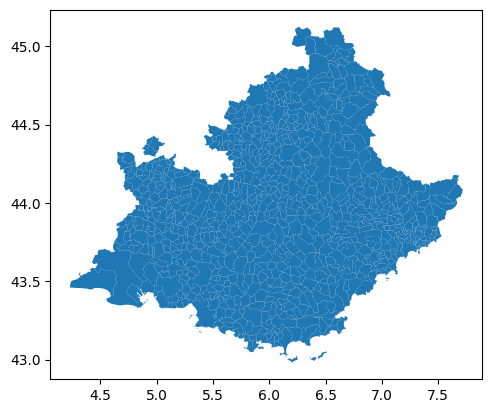

In [46]:
communes_bre.plot()

Affichage par commune, par route la plus proche (chaque commune est rattachée ici à sa route la plus proche) :

In [47]:
communes_bre['nearlier_road'].value_counts()

nearlier_road
1484    70
305     46
1474    31
1479    27
308     26
        ..
1463     1
397      1
304      1
1505     1
1496     1
Name: count, Length: 199, dtype: int64

In [48]:
communes_bre_spec = copy.copy(communes_bre)

In [49]:
communes_bre_spec['nearlier_road'] = communes_bre_spec['nearlier_road'].apply(lambda integer : str(integer))

<Axes: >

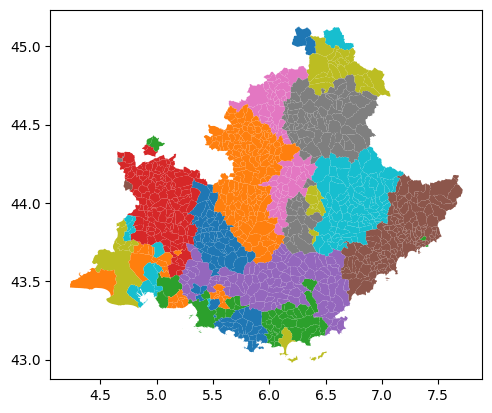

In [50]:
communes_bre_spec.plot(column='nearlier_road')

Amplification du poids du nombre de véhicule de la commune selon la distance à la route (racine quatrième par exemple) :

In [51]:
communes_bre['traffic_vp'] = communes_bre['nb_vp']/communes_bre['nearlier_road_dist']**(1/8)

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

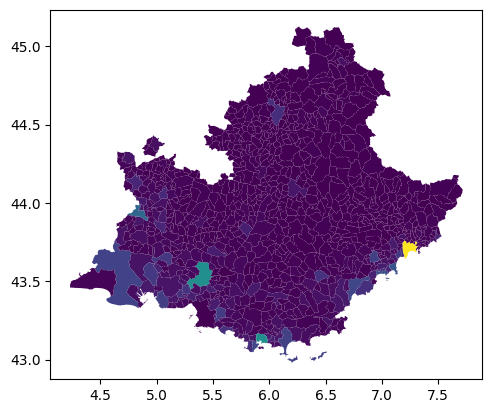

In [52]:
communes_bre.plot(column='nb_vp')

<Axes: >

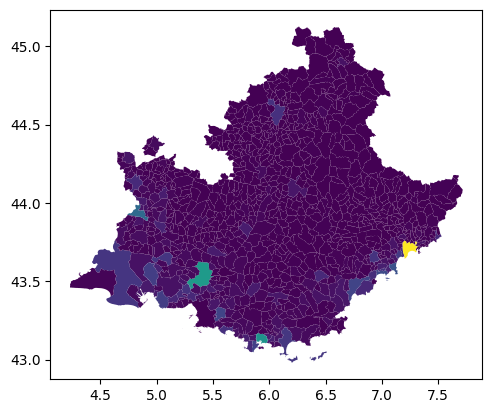

In [53]:
communes_bre.plot(column='traffic_vp')

Evaluation du trafic local de la route, comme somme (pour chaque commune) des voitures immatriculées / distance de chaque commune :

In [54]:
traffic_values = communes_bre.groupby('nearlier_road')['traffic_vp'].sum().to_dict()

Visualisation des routes qui ont des communes rattachées :

<Axes: >

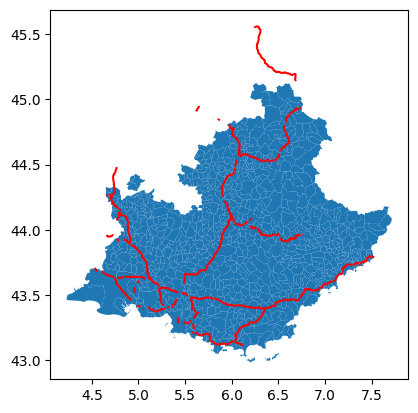

In [55]:
tmja_wrs84_bre_not_null = tmja_wrs84_clean.loc[tmja_wrs84_clean.index.isin(traffic_values.keys()),:]

fig, ax = plt.subplots(1, 1)

communes_bre.plot(ax=ax)
tmja_wrs84_bre_not_null.plot(ax=ax, color='r')

Le "rabattement" du traffic supposé local sur les routes produit une discontinuité. En effet, certaines routes n'ont aucune commune rattachée à elle... [Problème à éventuellement gérer avec une extrapolation moyenne des routes dépourvues de traffic à partir des plus proches voisines]

----------

In [58]:
to_keep = (tmja_wrs84_clean['xD']>=800000) & (tmja_wrs84_clean['xD']<=1600000) & (tmja_wrs84_clean['yD']<=6600000) & (tmja_wrs84_clean['yD']>=5500000)

tmja_wrs84_bre_clean = tmja_wrs84_clean.loc[to_keep,:]

In [59]:
tmja_wrs84_bre_clean['tmja_local'] = tmja_wrs84_bre_clean['road_index'].map(traffic_values)

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Extrapolation du traffic local pour les routes "orphelines" (rattachées )

In [62]:
tmja_wrs84_bre_clean = split_and_fill_Local_null_values_by_key(tmja_wrs84_bre_clean, 'tmja_local', missing_value='nan', nb_rep=15, buffer_size=0.01)

cannot insert road_index, already exists


/tmp/ipykernel_52500/3422367474.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_buf = df_clean.buffer(buffer_size)


... 1 rounds done. 14 are been modified... Total values modified : 14
... 2 rounds done. 11 are been modified... Total values modified : 25
... 3 rounds done. 10 are been modified... Total values modified : 35
... 4 rounds done. 7 are been modified... Total values modified : 42
... 5 rounds done. 6 are been modified... Total values modified : 48
... 6 rounds done. 4 are been modified... Total values modified : 52
... 7 rounds done. 2 are been modified... Total values modified : 54
... 8 rounds done. 1 are been modified... Total values modified : 55
... 9 rounds done. 0 are been modified... Total values modified : 55
... 10 rounds done. 0 are been modified... Total values modified : 55
... 11 rounds done. 0 are been modified... Total values modified : 55
... 12 rounds done. 0 are been modified... Total values modified : 55
... 13 rounds done. 0 are been modified... Total values modified : 55
... 14 rounds done. 0 are been modified... Total values modified : 55
... 15 rounds done. 0 are 

<Axes: >

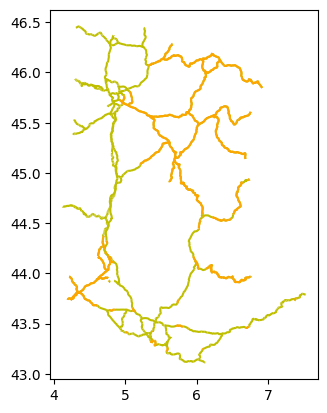

In [63]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84_bre_clean.loc[tmja_wrs84_bre_clean['tmja_local']>0,:].plot(ax=ax, color='y')
tmja_wrs84_bre_clean.loc[(tmja_wrs84_bre_clean['tmja_local']>0) & (tmja_wrs84_bre_clean['tmja_local']<3000),:].plot(ax=ax, color='orange')
#tmja_wrs84_bre_clean.loc[tmja_wrs84_bre_clean['tmja_local']==0,:].plot(ax=ax, color='r')

Problème de discontinuité résolue

-------

Application de la formule du sous-score 2 :

In [85]:
tmja_wrs84_bre_clean[['tmja', 'tmja_local']].describe()

,tmja,tmja_local
count,1342.000000,1342.000000
mean,27839.419519,4957.041071
std,27045.758888,9937.252796
min,42.605519,30.126337
25%,9453.000000,595.823030
50%,16916.000000,3766.268142
75%,39407.000000,3766.268142
max,158320.000000,133279.946830


In [86]:
fig = px.histogram(tmja_wrs84_bre_clean, x='tmja', nbins=200)
fig.show()

In [87]:
fig = px.histogram(tmja_wrs84_bre_clean, x='tmja_local', nbins=200)
fig.show()

In [88]:
alpha = 1

In [89]:
tmja_wrs84_bre_clean['tmja_tourist'] = (tmja_wrs84_bre_clean['tmja'] / tmja_wrs84_bre_clean['longueur']) - alpha * tmja_wrs84_bre_clean['tmja_local']

In [90]:
min(tmja_wrs84_bre_clean['tmja_tourist'])

-133262.81294800082

In [91]:
max(tmja_wrs84_bre_clean['tmja_tourist'])

458963.7319655267

In [92]:
fig = px.histogram(tmja_wrs84_bre_clean, x='tmja_tourist', nbins=200)
fig.show()

In [93]:
mean_tmja = tmja_wrs84_bre_clean['tmja_tourist'].mean()
std_tmja = tmja_wrs84_bre_clean['tmja_tourist'].std()

In [94]:
mean_tmja

-3581.026538124354

In [95]:
std_tmja

22835.174407904986

In [96]:
def fill_values(value):
    if value < mean_tmja - std_tmja:
        new_value = mean_tmja - std_tmja
    elif value > mean_tmja + std_tmja:
        new_value = mean_tmja + std_tmja
    else:
        new_value = value
    return new_value

In [97]:
tmja_wrs84_bre_clean['tmja_tourist'] = tmja_wrs84_bre_clean['tmja_tourist'].apply(lambda value : fill_values(value))

In [98]:
minimum_value = min(tmja_wrs84_bre_clean['tmja_tourist'])

if minimum_value<0:

    tmja_wrs84_bre_clean['tmja_tourist'] = tmja_wrs84_bre_clean['tmja_tourist'] - minimum_value

In [99]:
fig = px.histogram(tmja_wrs84_bre_clean, x='tmja_tourist', nbins=200)
fig.show()

---------

In [100]:
def fast_visualization_specific_tmja(base_geo_df, geo_df, colum_key):
    max_value = max(geo_df[colum_key])
    fig, ax = plt.subplots(1, 1)

    base_geo_df.plot(ax=ax, color='grey')
    geo_df.plot(ax=ax, color='grey')
    geo_df.loc[geo_df[colum_key]>max_value*0.1,:].plot(ax=ax, color='blue')
    geo_df.loc[geo_df[colum_key]>max_value*0.3,:].plot(ax=ax, color='green')
    geo_df.loc[geo_df[colum_key]>max_value*0.5,:].plot(ax=ax, color='y')
    geo_df.loc[geo_df[colum_key]>max_value*0.7,:].plot(ax=ax, color='orange')
    geo_df.loc[geo_df[colum_key]>max_value*0.9,:].plot(ax=ax, color='r')
    fig.show()



TMJA TOTAL

/tmp/ipykernel_52500/503064898.py:12: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



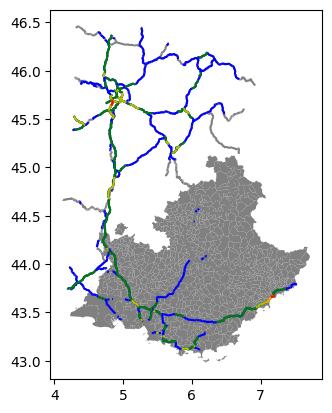

In [101]:
fast_visualization_specific_tmja(communes_bre, tmja_wrs84_bre_clean, 'tmja')

TMJA LOCAL

/tmp/ipykernel_52500/503064898.py:12: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



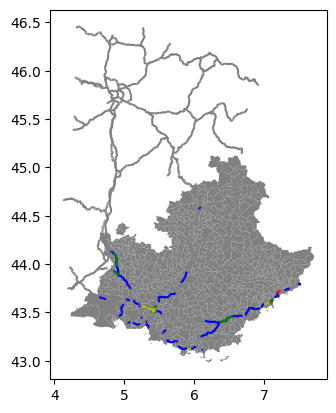

In [102]:
fast_visualization_specific_tmja(communes_bre, tmja_wrs84_bre_clean, 'tmja_local')

TMJA TOURISTIQUE

/tmp/ipykernel_52500/503064898.py:12: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



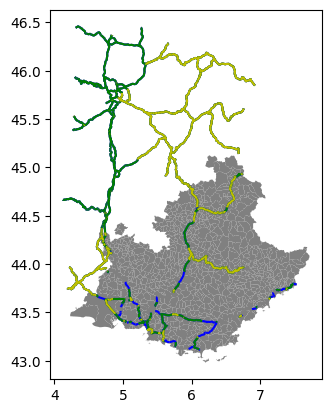

In [103]:
fast_visualization_specific_tmja(communes_bre, tmja_wrs84_bre_clean, 'tmja_tourist')

In [105]:
communes_bre.keys()

Index(['insee', 'nom', 'wikipedia', 'surf_ha', 'geometry', 'PMUN', 'PCAP',
       'PTOT', 'nb_vp', 'libepci', 'libgeo', 'nb_vp_rechargeables_gaz',
       'date_arrete', 'epci', 'nb_vp_rechargeables_el', 'dep', 'dep_name',
       'region_name', 'coords_centre', 'nearlier_road', 'nearlier_road_dist',
       'traffic_vp'],
      dtype='object')